# Fit the complete data (With sWeights and without sWeights)
This file is fitting for different cuts on the BDT variable

- Fit on $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit on $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Background of partially reconstructed decays $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- h$ (gaussian)
    - Combinatorial background (exponential)
    
    The ratio of yield $\frac{n_{B^0 \to D^{*-} K^+ \pi^+ \pi^-}}{n_{B^0 \to D^{*-} \pi^+ \pi^+ \pi^-}}$is fixed at the value found without any cut on the `BDT` output.

Those two fits are not simultaneous



## Import

In [1]:
import zfit
import json
import numpy as np
import timeit

from math import sqrt

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import launch_fit, define_zparams, save_params

Welcome to JupyROOT 6.22/02


## Load

In [2]:
# Mean of the distribution of the partially reconstructed data
with open(f'{loc.JSON}/data_strip_p/all_data_strip_params.json', 'r') as f:
    mu2_p = json.load(f)['mu2']


In [3]:
df_common = load_data(years, magnets, type_data='common', vars=['B0_M', 'BDT'],
                            cut_DeltaM=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/all_common.root


In [4]:
name_data = 'common_cutDeltaM_V8_rFixed'
name_data_B0Ds = 'common_cutDeltaM_Ds_recomp_weighted_V8'

Loading of $\sigma_R$, $\sigma_L$, `frac` and $\mu$ of the signal shape, of the `common` data.
Those values will be used to integrate the combinatorial PDF in order to get the number of background under the signal peak.

In [5]:
name_full_common = "all_common_cutDeltaM_V8_fixedTails"
with open(f'{loc.JSON}/{name_full_common}_params.json', 'r') as f:
    common_params = json.load(f)


sigmaR = common_params['sigmaR']
sigmaL = common_params['sigmaL']
frac = common_params['frac']
sigm = sqrt((frac*sigmaL)**2 + ((1 - frac)*sigmaR)**2)
sigm2 = frac*sigmaL + (1 - frac)*sigmaR
mea = common_params['mu']
r_bkgK = common_params['r_bkgK']
print('sigm', sigm)
print('sigm2', sigm2)
print('r_bkgK', r_bkgK)

sigm 14.623778731824565
sigm2 18.568495396578285
r_bkgK 0.032785384091824694


## cut on BDT

In [88]:
cut_BDT = -0.24
k = str(cut_BDT)

In [89]:
df = df_common.query(f"BDT > {cut_BDT}")

In [90]:
# File saved in 
df_Ds = load_data(years, magnets, type_data='common', vars=['B0_M', 'BDT', 'sWeight'],
                            cut_DeltaM=True, cut_tau_Ds=True, cut_BDT=cut_BDT)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_B0toDstDs_BDT-0.24.root


### Reference
Reference fit whose results are taken as the starting values of the new fit. It is specified by cut_BDT_ref, the cut on the BDT output. If None, the reference fit is the one performed without any cut on the BDT output.

In [91]:
cut_BDT_ref = None # put to None for the reference to be the fit without any cut on the BDT output

In [92]:
def format_previous_params(df_params_recup):
    """ Remove the element in the dictionnary that ends with '_err'.
    For the other ones, removes what is after | in the keys.
    In particular: variable|BDT-0.2 will become variable
    
    @df_params_recup  :: dataframe with the result of the file 
                            this is the df saved in .json after the fit.
                            
    @returns          :: new dataframe
    """
    df_params_recup_formatted = {}
    for key, value in df_params_recup.items():
        if not key.endswith('_err'):
            index = key.find('|')
            df_params_recup_formatted[key[:index]] = value
    
    return df_params_recup_formatted

In [93]:
if cut_BDT_ref is None:
    with open(f'{loc.JSON}/{name_full_common}_params.json', 'r') as f:
        params_r = json.load(f)
    with open(f'{loc.JSON}/all_common_cutDeltaM_Ds_weighted_V8_params.json', 'r') as f:
        B0Ds_params_r = json.load(f)
    
else:
    with open(f'{loc.JSON}/{name_data}_BDT{cut_BDT_ref}_params.json', 'r') as f:
        params_recup = json.load(f)

    params_r = format_previous_params(params_recup)
    
    with open(f'{loc.JSON}/{name_data_B0Ds}_BDT{cut_BDT_ref}_params.json', 'r') as f:
        B0Ds_params_recup = json.load(f)
    
    B0Ds_params_r = format_previous_params(B0Ds_params_recup)

## Fit on weighted `B0_M` with `|tau_M-1969|<50`

### Data

In [94]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

In [95]:
low_B0Ds = 5150.
high_B0Ds = 5360.

### Distributions

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:631: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


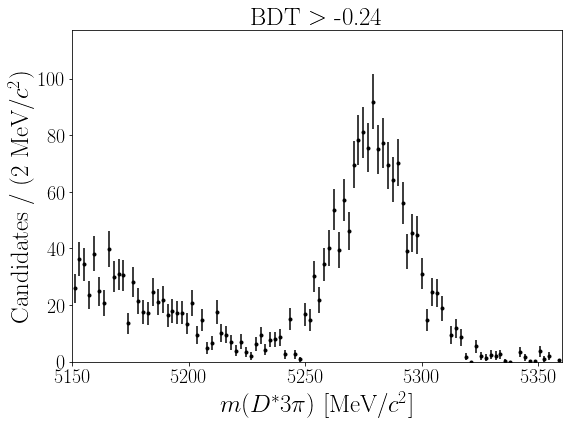

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_common_cutDeltaM_Ds_recomp_weighted_V8_BDT-0.24.pdf


In [96]:
h.plot_hist_particle({name_data_B0Ds:df_Ds},'B0_M',
              low = low_B0Ds, high = high_B0Ds, cut_BDT = k,
              n_bins = 100, mode_hist = False, colors='black', weights=df_Ds['sWeight'])

### Intial values

In [97]:
n_events_B0Ds = len(df_Ds.query(f'B0_M > {low_B0Ds} and B0_M < {high_B0Ds}'))

n_sig_k = B0Ds_params_r['n_sig_B0Ds']
n_bkg_k = B0Ds_params_r['n_bkg_B0Ds']
n_bkg2_k = B0Ds_params_r['n_bkg2_B0Ds']

initial_values_B0Ds = {
    # Signal
    'mu_B0Ds'       :{ 'value': B0Ds_params_r['mu_B0Ds']      , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
    'sigma_B0Ds'    :{ 'value': B0Ds_params_r['sigma_B0Ds']   , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
    'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Combinatorial background
    'lambda_B0Ds'   :{ 'value': B0Ds_params_r['lambda_B0Ds']  , 'low': -0.1           , 'high': -0.0000001           , 'floating': True},
    'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Partially reconstructed particles
    'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2_B0Ds'   :{ 'value': B0Ds_params_r['sigma2_B0Ds']  , 'low': 50.            , 'high': 90.                  , 'floating': True},
    'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
}

## For cut_BDT >= 0.2
# initial_values_B0Ds = {
#     # Signal
#     'mu_B0Ds'       :{ 'value': B0Ds_params_r['mu_B0Ds']      , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
#     'sigma_B0Ds'    :{ 'value': B0Ds_params_r['sigma_B0Ds']   , 'low': 15.-2.        , 'high': 15.+2.                , 'floating': True},
#     'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
#     # Combinatorial background
#     'lambda_B0Ds'   :{ 'value': -0.001                        , 'low': -0.15          , 'high': -0.000000001         , 'floating': False},
#     'n_bkg_B0Ds'    :{ 'value': 0                             , 'low': 0              , 'high': n_events_B0Ds        , 'floating': False},
#     # Partially reconstructed particles
#     'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
#     'sigma2_B0Ds'   :{ 'value': B0Ds_params_r['sigma2_B0Ds']  , 'low': 30.            , 'high': 80.                  , 'floating': True},
#     'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0.              , 'high': n_events_B0Ds        , 'floating': True},
# }

### Observables and variables

In [98]:
obs_B0Ds = zfit.Space("x", limits=(low_B0Ds, high_B0Ds))

zparams_B0Ds = define_zparams(initial_values_B0Ds, cut_BDT=cut_BDT)

In [99]:
name_params_B0Ds = {
    # Signal
    f'mu_B0Ds|BDT{cut_BDT}'      : '$\mu_S$',
    f'sigma_B0Ds|BDT{cut_BDT}'   : '$\\sigma_S$',
    f'n_sig_B0Ds|BDT{cut_BDT}'   : '$n_S$',
    # Combinatorial background
    f'n_bkg_B0Ds|BDT{cut_BDT}'   : '$n_{B,c}$',
    f'lambda_B0Ds|BDT{cut_BDT}'  : '$\\lambda_{B,c}$',
    # Partially reconstructed background
    f'mu2_B0Ds|BDT{cut_BDT}'     : '$\\mu_{B, D^*3 D_s h}$',
    f'sigma2_B0Ds|BDT{cut_BDT}'  : '$\\sigma_{B, D^* D_s h}$',
    f'n_bkg2_B0Ds|BDT{cut_BDT}'  : '$n_{B, D^* D_s h}$',
}

### PDFs

In [100]:
gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds[f'mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)
exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)

gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
data_B0Ds = zfit.Data.from_pandas(df_Ds['B0_M'], obs=obs_B0Ds, weights=df_Ds['sWeight'])

### Fitting

In [101]:
start = timeit.default_timer()
result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4035                   |     Ncalls=323 (323 total)     |
| EDM = 8.93e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:46: ExperimentalFeatureWarning: The computation of the covariance matrix with weights is still experimental.
  ExperimentalFeatureWarning)


name                       value    minuit_hesse    at limit
--------------------  ----------  --------------  ----------
n_sig_B0Ds|BDT-0.24         1391     +/-      40       False
n_bkg_B0Ds|BDT-0.24        100.2     +/-      53       False
n_bkg2_B0Ds|BDT-0.24       734.8     +/-      45       False
mu_B0Ds|BDT-0.24            5280     +/-    0.63       False
sigma_B0Ds|BDT-0.24        15.03     +/-    0.58       False
lambda_B0Ds|BDT-0.24  -1.615e-06     +/- 0.00013       False
sigma2_B0Ds|BDT-0.24       73.63     +/-     3.7       False
------------------------------------------------------------------
| FCN = -4035                   |      Ncalls=97 (97 total)      |
| EDM = 4.34e-06 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |    

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:631: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


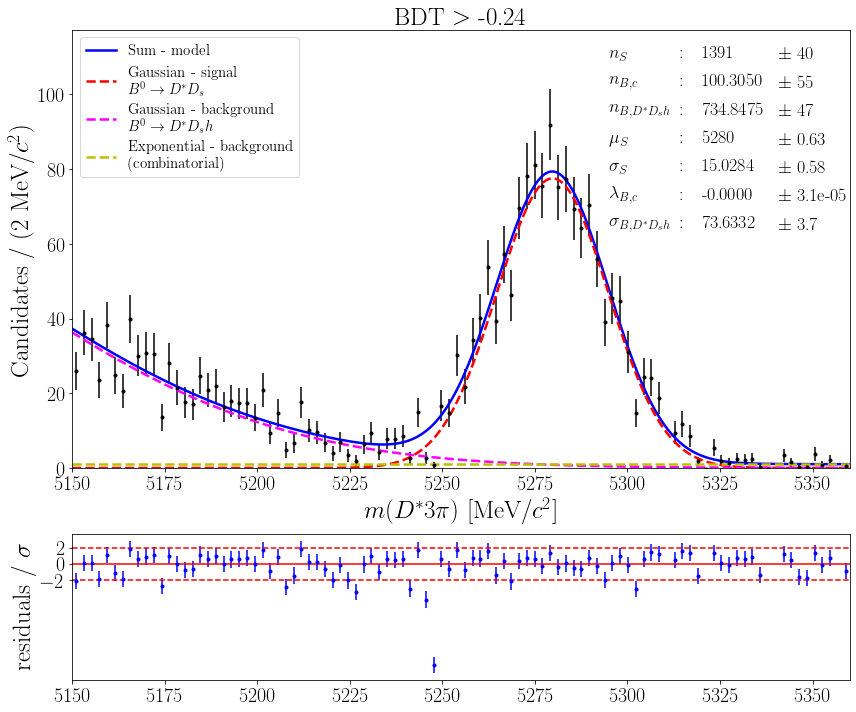

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_cutDeltaM_V8_rFixed/B0_M_common_cutDeltaM_Ds_recomp_weighted_V8_fit_BDT-0.24.pdf


/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:631: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


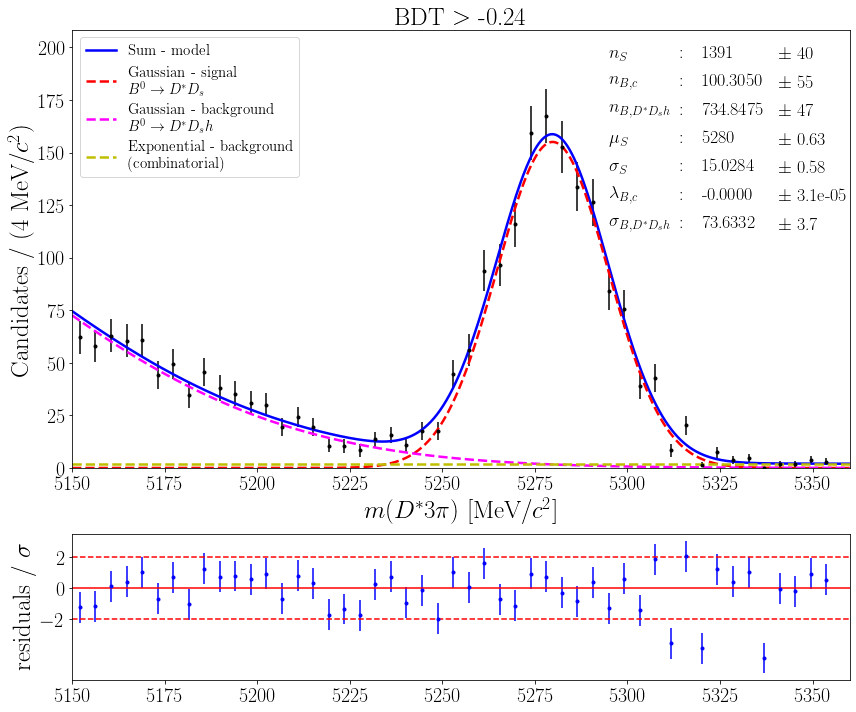

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_cutDeltaM_V8_rFixed/B0_M_common_cutDeltaM_Ds_recomp_weighted_V8_fit_BDT-0.24.pdf


In [102]:
name_data_B0Ds_plot = name_data_B0Ds
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'], cut_BDT=k,
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data = name_data_B0Ds, name_folder=name_data,
                       colors=['b','r','magenta','y'], weights=df_Ds['sWeight'],
                       params=params_B0Ds,name_params=name_params_B0Ds,
                       colWidths=[0.05,0.01,0.05,0.04],
                       fontsize_res = 18.,
                       fontsize_leg=15)

n_bins=50
name_data_B0Ds_plot = name_data_B0Ds+str(n_bins)

plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'], cut_BDT=k,
                       obs=obs_B0Ds, n_bins = n_bins,mode_hist = False,
                       name_data = name_data_B0Ds, name_folder=name_data,
                       colors=['b','r','magenta','y'], weights=df_Ds['sWeight'],
                       params=params_B0Ds,name_params=name_params_B0Ds,
                       colWidths=[0.05,0.01,0.05,0.04],
                       fontsize_res = 18.,
                       fontsize_leg=15)

In [103]:
save_params(params_B0Ds, name_data_B0Ds+f'_BDT{cut_BDT}', True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_cutDeltaM_Ds_recomp_weighted_V8_BDT-0.24_params.json


## Fit on the full `B0_M`

### Data

In [104]:
# Result of the fit on the MC D0S->D*pipipi data with one of the pi misidentified as a kaon
with open(f'{loc.JSON}/data_KPiPi_2_params.json', 'r') as f:
    data_KPiPi_params = json.load(f)

for var in 'muL', 'muR', 'sigmaL', 'sigmaR': # conversion GeV -> MeV
    data_KPiPi_params[var] = data_KPiPi_params[var]*1000
    data_KPiPi_params[f"{var}_err"] = data_KPiPi_params[f"{var}_err"]*1000    
    
# Result of the previous fit on the B0_M sWeighted distribution with cut on tau_M around m(Ds)
with open(f'{loc.JSON}/{name_data_B0Ds}_BDT{cut_BDT}_params.json', 'r') as f:
    data_B0Ds_params = json.load(f)


    
# Result of the fit on the MC signal data
with open(f'{loc.JSON}/MC_params.json', 'r') as f:
    MC_param_results = json.load(f)

In [105]:
low = 5150.
high = 5550.

### Distribution

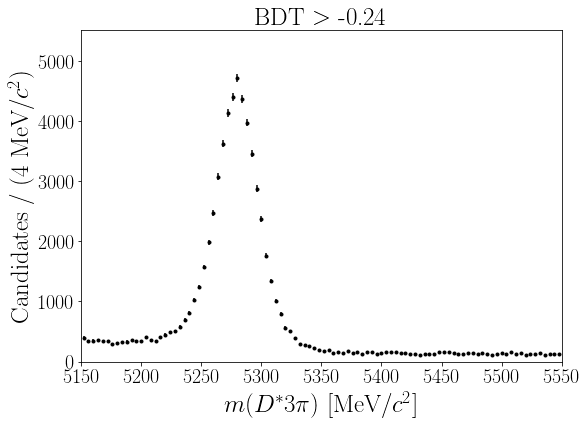

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_common_cutDeltaM_V8_rFixed_BDT-0.24.pdf


In [106]:
h.plot_hist_particle({name_data:df},'B0_M',
              low = low, high = high, cut_BDT=cut_BDT,
              n_bins = 100, mode_hist = False, colors='black')

### Initial values

In [107]:
n_events_B0_M = len(df.query(f'B0_M > {low} and B0_M < {high}'))

n_sig_k = params_r['n_sig']
n_bkg_k = params_r['n_bkg']
n_bkg2_k = params_r['n_bkg2']

initial_values = {
    # Signal        
    'mu'       :{ 'value': params_r['mu']                , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
    'sigmaL'   :{ 'value': params_r['sigmaL']            , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
    'sigmaR'   :{ 'value': params_r['sigmaR']            , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
    'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
    'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                , 'floating': False},
    'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
    'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
    'frac'     :{ 'value': params_r['frac']              , 'low': 0.1              , 'high': 1.                 , 'floating': True},
    'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': params_r['lambda']            , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
    'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Partially reconstructed particles        
    'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2'   :{ 'value': params_r['sigma2']            , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': True},
    'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    # Background decay D*Kpipi    
#     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    'r_bkgK'   :{ 'value': r_bkgK                        , 'low': 0.0001          , 'high': 0.5                   , 'floating': False},
}


# For cut_BDT >= 0.2
# with open(f'{loc.JSON}/{name_data}_BDT-0.15_params.json', 'r') as f:
#     sigma2 = json.load(f)['sigma2|BDT-0.15']

# initial_values = {
#     # Signal        
#     'mu'       :{ 'value': params_r['mu']                , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
#     'sigmaL'   :{ 'value': params_r['sigmaL']            , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
#     'sigmaR'   :{ 'value': params_r['sigmaR']            , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
#     'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
#     'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                , 'floating': False},
#     'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
#     'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
#     'frac'     :{ 'value': params_r['frac']              , 'low': 0.1              , 'high': 1.                 , 'floating': True},
#     'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Combinatorial background        
#     'lambda'   :{ 'value': params_r['lambda']            , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
#     'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Partially reconstructed particles        
#     'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
#     'sigma2'   :{ 'value': sigma2                        , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': False},
#     'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
#     # Background decay D*Kpipi    
# #     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
#     'r_bkgK'   :{ 'value': r_bkgK                        , 'low': 0.0001          , 'high': 0.5                   , 'floating': False},
# }


for var in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{var}_K'] = {'value': data_KPiPi_params[var], 'low': None, 'high': None, 'floating': False}

for var in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{var}_Ds'] = {'value': data_B0Ds_params[f'{var}_B0Ds|BDT{cut_BDT}'], 'low': None, 'high': None, 'floating': False}

In [108]:
print(params_r)

{'frac': 0.36597131077116174, 'frac_err': 0.04477506730478005, 'lambda': -0.0009777775211016401, 'lambda_err': 0.00013214752145974877, 'mu': 5279.670672196767, 'mu_err': 0.10997239662751408, 'n_bkg': 30227.08034829059, 'n_bkg2': 374.4189048511811, 'n_bkg2_err': 98.06063968504371, 'n_bkg_err': 487.8285911284329, 'n_sig': 51946.003209612085, 'n_sig_err': 389.070934645212, 'r_bkgK': 0.032785384091824694, 'r_bkgK_err': 0.007686768256103177, 'sigma2': 33.46084345188925, 'sigma2_err': 5.115606474058789, 'sigmaL': 12.927803255733908, 'sigmaL_err': 0.5385460815292429, 'sigmaR': 21.824391433321082, 'sigmaR_err': 0.37977894852605804}


### Observables and variables

In [109]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values, cut_BDT=cut_BDT)

mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter(f"n_bkgK|BDT{cut_BDT}", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

In [110]:
name_params = {
    # Signal
    f'mu|BDT{cut_BDT}'      : '$\mu_S$',
    f'sigmaL|BDT{cut_BDT}'  : '$\\sigma_{L_S}$',
    f'sigmaR|BDT{cut_BDT}'  : '$\\sigma_{R_S}$',    
    f'alphaL|BDT{cut_BDT}'  : '$\\alpha_{L_S}$',
    f'alphaR|BDT{cut_BDT}'  : '$\\alpha_{R_S}$',
    f'nL|BDT{cut_BDT}'      : '$n_L_S$',
    f'nR|BDT{cut_BDT}'      : '$n_R_S$',
    f'frac|BDT{cut_BDT}'    : '$f_{S, \\frac{L}{R}}$',
    f'n_sig|BDT{cut_BDT}'   : '$n_S$',
    # Combinatorial background
    f'n_bkg|BDT{cut_BDT}'   : '$n_{B,c}$',
    f'lambda|BDT{cut_BDT}'  : '$\\lambda_{B,c}$',
    # Partially reconstructed brackground
    f'mu2|BDT{cut_BDT}'     : '$\\mu_{B,D^*3\pi h}$',
    f'sigma2|BDT{cut_BDT}'  : '$\\sigma_{B,D^*3\pi h}$',
    f'n_bkg2|BDT{cut_BDT}'  : '$n_{B,D^*3\pi h}$',
    # Background decay D*Kpipi    
    f'n_bkgK|BDT{cut_BDT}'  : '$n_{B,D^*K\pi\pi}$',
    f'r_bkgK|BDT{cut_BDT}'  : '$\\frac{n_{B,D^*K\pi\pi}}{n_S}$',
}


### PDFs

In [111]:
def crystall_ball_gaussian(mu, sigma, obs, alpha=None, n=None):
    if alpha is None or n is None:
        pdf = zfit.pdf.Gauss(mu, sigma, obs=obs)
    else:
        pdf = zfit.pdf.CrystalBall(mu, sigma, alpha, n, obs=obs)
    return pdf

def sum_crystalball(muL, muR, sigmaL, sigmaR, frac, obs, alphaL=None, alphaR=None, nL=None, nR=None):
    """ Return the sum of 2 crystall ball PDFs.
    If the alpha or n is None, the corresponding distribution is a gaussian.
    """
    pdfL = crystall_ball_gaussian(muL, sigmaL, obs,
                                         alphaL,nL)
    pdfR = crystall_ball_gaussian(muR, sigmaR, obs,
                                         alphaR, nR)
    
    model = zfit.pdf.SumPDF([pdfL, pdfR], fracs=frac)
    
    return model, pdfL, pdfR

In [112]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)
gaussian = zfit.pdf.Gauss(zparams['mu2'],zparams['sigma2'],obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_ext = gaussian.create_extended(zparams['n_bkg2'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df['B0_M'], obs=obs)

### Fit

Sometimes I perform 2 fits so that the last one converges

In [113]:
start = timeit.default_timer()
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -3.441e+05              |     Ncalls=470 (470 total)     |
| EDM = 0.000664 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name                 value    minuit_hesse    at limit
---------------  ---------  --------------  ----------
n_sig|BDT-0.24       49410     +/- 3.4e+02       False
n_bkg2|BDT-0.24        316     

For `cut_BDT = 0.15`

    ------------------------------------------------------------------
    | FCN = -1.321e+05              |     Ncalls=127 (127 total)     |
    | EDM = 0.000278 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name                value    minuit_hesse    at limit
    --------------  ---------  --------------  ----------
    n_sig|BDT0.15       24790     +/- 1.9e+02       False
    n_bkg2|BDT0.15      60.51     +/-      19       False
    n_bkg|BDT0.15        3504     +/- 1.3e+02       False
    frac|BDT0.15       0.2927     +/-   0.031       False
    mu|BDT0.15           5280     +/-    0.14       False
    sigmaL|BDT0.15      11.76     +/-     0.5       False
    sigmaR|BDT0.15      20.74     +/-    0.27       False
    sigma2|BDT0.15      11.31     +/- 1.8e-06       False
    lambda|BDT0.15  -0.004376     +/- 0.00026       False
    Time to do the fit:  6.594081127783284

    Info: VariableMetricBuilder: no improvement in line search
    Info: VariableMetricBuilder: iterations finish without convergence.
    Info in VariableMetricBuilder : edm = 17.1175
    Info in             requested : edmval = 0.001
    Info: VariableMetricBuilder: Edm has been re-computed after Hesse
    Info in new value is now smaller than the required tolerance, : edm = 0.000278307


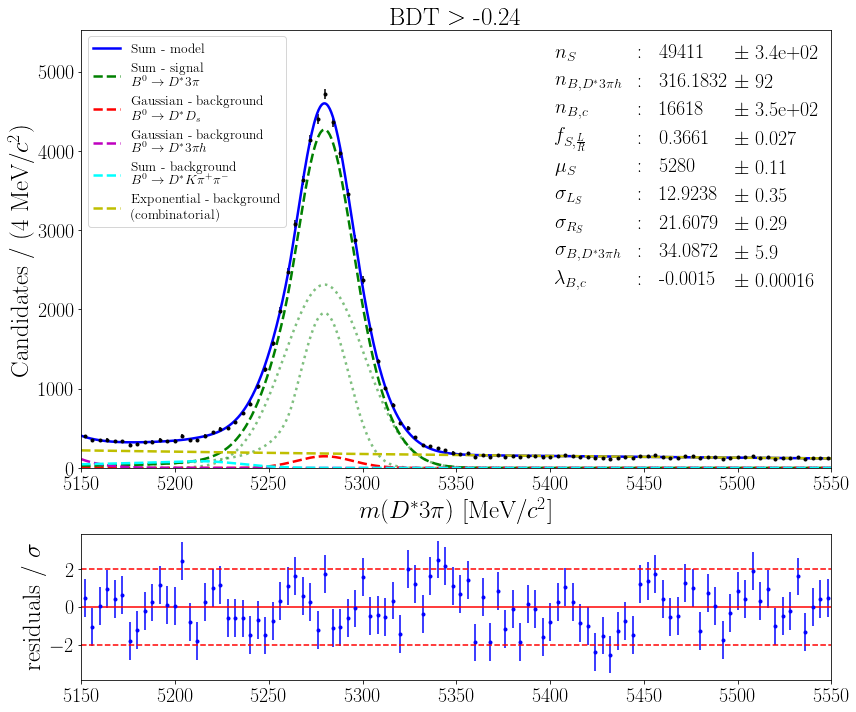

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_cutDeltaM_V8_rFixed/B0_M_common_cutDeltaM_V8_rFixed_detail_fit_BDT-0.24.pdf


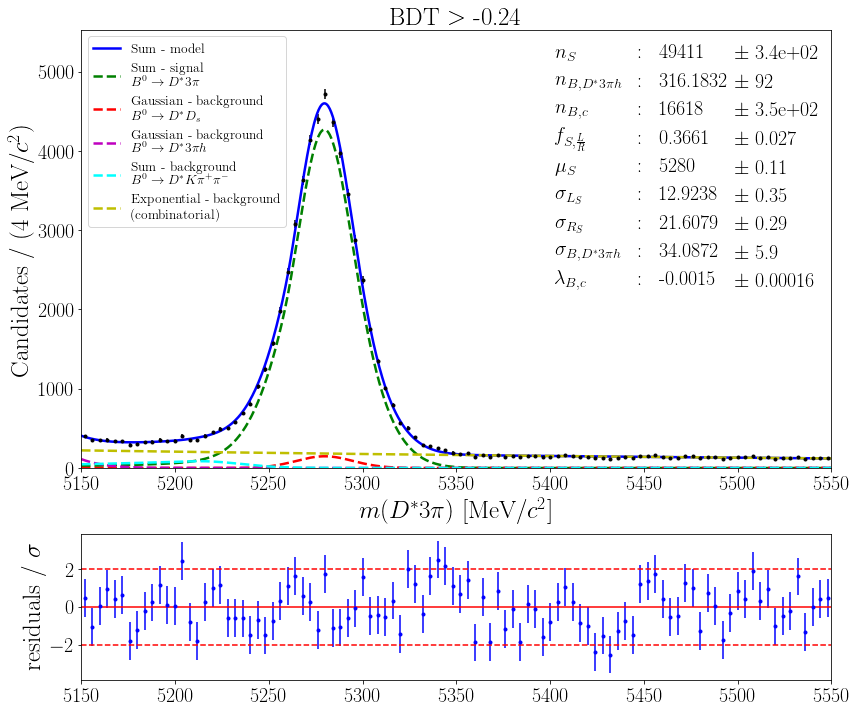

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_cutDeltaM_V8_rFixed/B0_M_common_cutDeltaM_V8_rFixed_fit_BDT-0.24.pdf


In [114]:
name_data_plot = name_data + '_detail'
plot_hist_fit_particle(df,'B0_M', models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       cut_BDT=cut_BDT,
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       params=params,name_params=name_params,
                       fontsize_leg=13.5,
                       colWidths=[0.06,0.01,0.05,0.06]
                      )
name_data_plot = name_data
plot_hist_fit_particle(df,'B0_M', models = [model,model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       cut_BDT=cut_BDT,
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       params=params,name_params=name_params,
                       fontsize_leg=13.5,
                       colWidths=[0.06,0.01,0.05,0.06]
                      )

### Computation of the number of events below the peak.

We define $\sigma_L$ and $\sigma_R$, the standard deviation of the Crystall ball signal PDFs obtained with the full `common` with only the $143\ MeV < \Delta M < 148\ MeV$ cut.
`frac`, noted $f$, is such that the total signal shape is $f_S = f_r\times p_L +(1-f) p_R$, where $p_L$ ($p_R$) is the left (right) Crystal ball PDF, with standard deviation $\sigma_L$ ($\sigma_R$).
The common mean of the two Crystal Ball PDF is denoted $\mu$

Then, we define the geometrical average $\sigma=\sqrt{(f\sigma_L)^2+((1-f)\sigma_R)^2}$ and the usual average $\sigma_2 = f\times \sigma_L + (1-f) \sigma_R$

The number of combinatorial background under the signal peak, for a given `cut_BDT` is noted `n_B` and computed by:
$$ n_B=\int_{\mu-3\sigma}^{{\mu+3\sigma}}{dx f_e(x, \lambda_{BDT})} \times n_{B,c} $$
Where $n_{B,c}$ is the number of background events between `low` and `high` where the fit is applied. $f_e$ is the exponential combinatorial background PDF.
We also compute this quantity for $\sigma_2$, denoted  $n_{B2}$ or `n_B2`.

Those two quantities and their errors are computed and saved together with the fitted parameters.

In [115]:
integral = float(exp_ext.analytic_integrate([mea-3*sigm, mea+3*sigm]))
integral2 = float(exp_ext.analytic_integrate([mea-3*sigm2, mea+3*sigm2]))

n_bkg = float(zparams['n_bkg'].value())
n_bkg_err = params[zparams['n_bkg']]['minuit_hesse']['error']
n_B = integral * n_bkg
n_B_err = integral * n_bkg_err

n_B2 = integral2 * n_bkg
n_B2_err = integral2 * n_bkg_err
print(n_B, n_B2)

3999.0992609449263 5080.169716574696


In [116]:
save_params(params,name_data + f"_BDT{cut_BDT}", True, {'n_B':n_B, 'n_B_err':n_B_err, 'n_B2':n_B2, 'n_B2_err':n_B2_err})

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_cutDeltaM_V8_rFixed_BDT-0.24_params.json
